# Reproduction of PPCA using Python

## PCA

First, let's construct the function to realize the classical PCA algorithm. In this place, $\mathbf{t}$ is the $d$-dimensional data matrix with a shape $d\times N$. $q$ is the dimension of the latent subspace and $\mathbf{W}$ is the set of $q$ principal axes. $\mathbf{W}$ is composed of $q$ eigenvectors corresponding to the maximal $q$ eigenvalues of the sample covariance matrix $\mathbf{S}$.

In [1]:
import numpy as np

def PCA(t, q):
    d, N = t.shape

    Mu = np.mean(t, axis=1).reshape(d, 1)
    S = np.zeros((d, d))

    for i in range(N):
        S = S + np.dot((t[:, i].reshape(d, 1) - Mu), (t[:, i].reshape(d, 1) - Mu).T)
    S = S / N

    _, W = np.linalg.eig(S)
    W = W[:, 0: q].real
    X = np.dot(W.T, (t - Mu))

    return X

## PPCA

In this part, the notation mainly refers to the paper of Tipping and Bishop: Probabilistic principal component analysis. The authors provided two methods to determine the parameters: maximum likelihood estimate and EM algorithm.

In the former one, $\mathbf{W}$ and $\sigma^2$ are calculated as:
\begin{equation}
\sigma^2=\sum\limits_{i=q+1}^{n}\lambda_i
\end{equation}
\begin{equation}
\mathbf{W}=\mathbf{U_q}(\mathbf{\Lambda}_q-\sigma^2\mathbf{I})^{1/2}\mathbf{R}
\end{equation}

where the $q$ column vectors in the $d\times q$ matrix $\mathbf{U}_q$ are the principal eigenvectors of $\mathbf{S}$, with corresponding eigenvalues $\lambda_1,\cdots,\lambda_q$ in the $q\times q$ diagonal matrix $\mathbf{\Lambda}_q$, and $\mathbf{R}$ is an arbitrary $q\times q$ orthogonal rotation matrix.

In EM algorithm, $\mathbf{W}$ and $\sigma^2$ are updated by:
\begin{equation}
\widetilde{\mathbf{W}}=\mathbf{SW}(\sigma^2\mathbf{I}+\mathbf{M}^{-1}\mathbf{W}^{\rm{T}}\mathbf{S}\mathbf{W})^{-1}
\end{equation}
\begin{equation}
\widetilde{\sigma^{2}}=\frac{1}{d}\rm{tr}(\mathbf{S}-\mathbf{SWM}^{-1}\widetilde{\mathbf{W}^{\rm{T}}})
\end{equation}

where $\mathbf{S}$ is given by:
\begin{equation}
\mathbf{S}=\frac{1}{N}\sum\limits_{n=1}^{N}(\mathbf{t}_n-\pmb{\mu})(\mathbf{t}_n-\pmb{\mu})^{\rm{T}}
\end{equation}

The first instance of $\mathbf{W}$ in equation is the old value of the parameter matrix, whereas the second instance $\widetilde{\mathbf{W}}$ is the new value of calculated from the equation.

After we get the parameter $\mathbf{W}$ and $\sigma^2$, the desired latent variable $\mathbf{x}$ can be summarized by the mean of the posterior distribution:

\begin{equation}
\mathbf{x}_n=\mathbf{M}^{-1}\mathbf{W}^{\rm{T}}(\mathbf{t}_n-\pmb{\mu})
\end{equation}
\begin{equation}
\mathbf{M}=\mathbf{W}^{\rm{T}}\mathbf{W}+\sigma^{2}\mathbf{I}
\end{equation}

At last, we could compute the log-likelihood of the model to evaluate if the update of parameters is right:

\begin{equation}
\mathcal{L}=-\frac{N}{2}(d\log(2\pi)+\log|\mathbf{C}|+\rm{tr}(\mathbf{C}^{-1}\mathbf{S}))
\end{equation}

We should supervise if the log-likelihood is increasing.

In [11]:
import numpy as np

def PPCA(t, q, epsilon = 0.001, method = 'ML'):
    d, N = t.shape
    Mu = np.mean(t, axis = 1).reshape(d, 1)
    S = np.zeros((d, d))

    for i in range(N):
        S += np.dot((t[:, i].reshape(d, 1) - Mu), (t[:, i].reshape(d, 1) - Mu).T)
    S /= N

    if method == 'ML':
        value, U = np.linalg.eig(S)
        U = U[:, 0: q]
        sigma_square = np.sum(value[q: d]) / (d - q)
        Lambda = np.diag(value[0: q])
        W = np.dot(U, np.sqrt(Lambda - sigma_square * np.identity(q)))
        W = W.real

        M = np.dot(W.T, W) + sigma_square * np.identity(q)
        X = np.dot(np.dot(np.linalg.inv(M), W.T), (t - Mu))

    if method == 'EM':
        value, U = np.linalg.eig(S)
        U = U[:, 0: q]
        U = U.real
        Lambda = np.diag(value[0: q])

        W_new = np.dot(U, np.sqrt(Lambda))
        W_old= np.dot(U, np.sqrt(Lambda))
        W_new = W_new.real
        W_old = W_old.real
        sigma_square_new = 1
        sigma_square_old = 5

        while (np.sqrt(np.sum(np.square(W_new - W_old))) > epsilon) | (abs(sigma_square_new-sigma_square_old) > epsilon):
            M = np.dot(W_new.T, W_new) + sigma_square_new * np.identity(q)
            W_old = W_new
            sigma_square_old = sigma_square_new
            W_new = np.dot(np.dot(S, W_old), np.linalg.inv(sigma_square_old * np.identity(q) + np.dot(np.linalg.inv(M), np.dot(W_old.T, np.dot(S, W_old)))))
            sigma_square_new = np.trace(S - np.dot(S, np.dot(W_old, np.dot(np.linalg.inv(M), W_new.T))))/d

            C = np.dot(W_new, W_new.T) + sigma_square_new * np.identity(d)
            L = -N * (d * np.log(np.pi) + np.log(np.linalg.det(C)) + np.trace(np.dot(np.linalg.inv(C), S))) / 2
            print("updated log-likelihood:", L)

        M = np.dot(W_new.T, W_new) + sigma_square_new * np.identity(q)
        X = np.dot(np.linalg.inv(M), np.dot(W_new.T, (t - Mu)))

    return X


It must be emphasized that EM algorithm is very sensitive to the choice of the initial value. So in the code above the initial value of $\mathbf{W}$ is chosen to be: $\mathbf{U}_q\mathbf{\Lambda}_q^{1/2}$. This ensures $\mathbf{W}$ converge to the correct value. It could be proved in the next example.

## Example 1: Tobamovirus data

In this part we run the code above on the 18-dimensional Tobamovirus dataset. This is obtained from the website: https://www.stats.ox.ac.uk/pub/PRNN/virus3.dat.

updated log-likelihood: -1009.221289300422
updated log-likelihood: -1008.9229632731564
updated log-likelihood: -1008.9110101927109
updated log-likelihood: -1008.9040174504601
updated log-likelihood: -1008.8984419407349
updated log-likelihood: -1008.8939761338859
updated log-likelihood: -1008.8904011622974
updated log-likelihood: -1008.887540801066
updated log-likelihood: -1008.8852531812654
updated log-likelihood: -1008.8834242560754
updated log-likelihood: -1008.8819624563354
updated log-likelihood: -1008.8807943373678
updated log-likelihood: -1008.8798610444609
updated log-likelihood: -1008.8791154506403
updated log-likelihood: -1008.8785198441618
updated log-likelihood: -1008.8780440638575
updated log-likelihood: -1008.8776639981911
updated log-likelihood: -1008.8773603788784
updated log-likelihood: -1008.8771178125086
updated log-likelihood: -1008.876924004071
updated log-likelihood: -1008.8767691349427
updated log-likelihood: -1008.876645365008
updated log-likelihood: -1008.876546

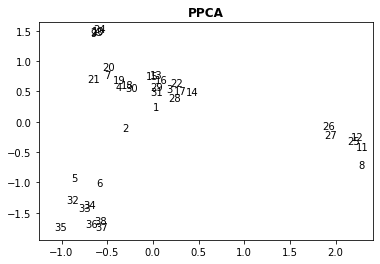

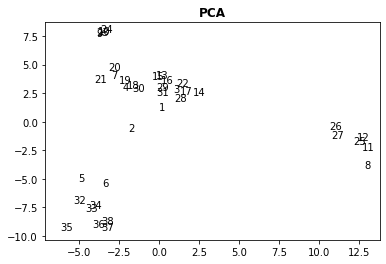

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


tobamovirus = pd.read_csv('D:/statistics/CUHK_PPCA/data/tobamovirus.csv')
data = np.array(tobamovirus, dtype=float).T

ppca_data = PPCA(data, 2, 0.001, method='EM')
plt.scatter(ppca_data[0, :], ppca_data[1, :], c = 'w')
plt.title('PPCA', fontsize='large', fontweight='bold')
for i in range(38):
    plt.text(ppca_data[0, i], ppca_data[1, i], i+1)
plt.show()

pca_data = PCA(data, 2)
plt.scatter(pca_data[0, :], pca_data[1, :], c = 'w')
plt.title('PCA', fontsize='large', fontweight='bold')
for i in range(38):
    plt.text(pca_data[0, i], pca_data[1, i], i+1)
plt.show()

## Example 2: Mixture model of PPCA

Tipping and Bishop raised another model based on PPCA in their paper: Mixture of Probabilistic Principal Component Analysers. The association of a probability model with PCA offers the tempting prospect of being able to model complex data structures with a combination of local PCA models.

In PPCA, the probabilistic function of each example is as follows:
\begin{equation}
p(\mathbf{t})=(2\pi)^{-d/2}|\mathbf{C}|^{-1/2}\exp\{-\frac{1}{2}(\mathbf{t}-\pmb{\mu})^{\rm{T}}\mathbf{C}^{-1}(\mathbf{t}-\pmb{\mu})\}
\end{equation}
\begin{equation}
\mathbf{C}=\sigma^{2}\mathbf{I}+\mathbf{WW}^{\rm{T}}
\end{equation}

In mixture model, however, the log-likelihood of observing the data set for such a mixture model is:
\begin{equation}
\mathcal{L}=\sum\limits_{n=1}^{N}\ln\{p(\mathbf{t}_n)\}
\end{equation}
\begin{equation}
=\sum\limits_{n=1}^{N}\ln\{\sum\limits_{i=1}^{M}\pi_ip(\mathbf{t}_n|i)\}
\end{equation}

where $p(\mathbf{t}|i)$ is a single PPCA model and $\pi_i$ is the corresponding mixing proportion, with $\pi_i\ge0$ and $\sum\pi_i=1$. Each single model has its parameters: $\pmb{\mu}_i$, $\mathbf{W}_i$ and $\sigma_i^{2}$.

We can develop an iterative EM algorithm for optimization of model parameters. If $R_{ni}=p(i|\mathbf{t}_n)$ is the posterior responsibiility of mixture $i$ for generating data point $\mathbf{t}_n$, given by:
\begin{equation}
R_{ni}=\frac{p(\mathbf{t}_n|i)\pi_i}{p(\mathbf{t}_n)}
\end{equation}

Then we obtain the following parameter updates:
\begin{equation}
\widetilde{\pi_i}=\frac{1}{N}\sum\limits_{n=1}^{N}R_{ni}
\end{equation}
\begin{equation}
\widetilde{\mu_i}=\frac{\sum\limits_{n=1}^{N}R_{ni}\mathbf{t}_n}{\sum\limits_{n=1}^{N}R_{ni}}
\end{equation}

where $\mathbf{S}_i$ is the local responsibility-weighted covariance matrix:
\begin{equation}
\mathbf{S}_i=\frac{1}{\widetilde{\pi_i}N}\sum\limits_{n=1}^{N}R_{ni}(\mathbf{t}_n-\widetilde{\pmb{\mu}_i})(\mathbf{t}_n-\widetilde{\pmb{\mu}_i})^{\rm{T}}
\end{equation}

Furthermore, for a given data point $\mathbf{t}$, there is now a posterior distribution associated with each latent space, the mean of which for space $i$ is given by $(\sigma^2_i\mathbf{I}+\mathbf{W}_i^{\rm{T}}\mathbf{W}_i)^{-1}\mathbf{W}_i^{\rm{T}}(\mathbf{t}_i-\pmb{\mu})$.

In the end, we can also calculate the log-likelihood for each update. If the log-likelihood is always increasing, it is highly possible that the programming is correct:

\begin{equation}
\mathcal{L}=\sum\limits_{n=1}^{N}(\log(p(\mathbf{t_n})))
\end{equation}

\begin{equation}
=\sum\limits_{n=1}^{N}(\log(\sum\limits_{i=1}^{M}\pi_ip(\mathbf{t_n}|i)))
\end{equation}

\begin{equation}
=\sum\limits_{n=1}^{N}\sum\limits_{i=1}^{M}R_{ni}\log(p(\mathbf{t_n}|i))
\end{equation}

the updated log-likelihood is: -1222.916152629902
the updated log-likelihood is: -1096.8534972844634
the updated log-likelihood is: -993.9478997677971
the updated log-likelihood is: -970.7607232230117
the updated log-likelihood is: -967.0051819416805
the updated log-likelihood is: -953.1981980747502
the updated log-likelihood is: -952.803184003227
the updated log-likelihood is: -952.8031840031592

 Pi =  [0.57893908 0.26315789 0.15790303]


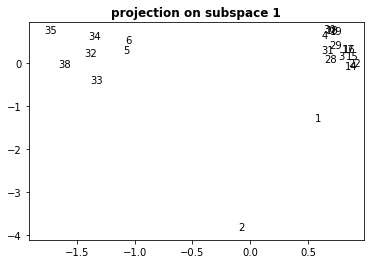

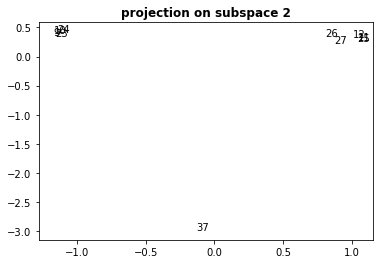

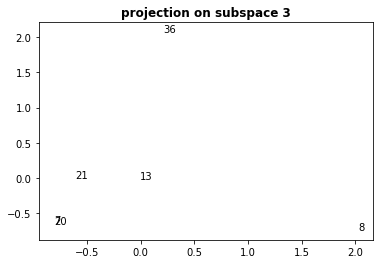

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tobamovirus = pd.read_csv('D:/statistics/CUHK_PPCA/data/tobamovirus.csv')
data = np.array(tobamovirus, dtype=float).T

t = data
d, N = data.shape
q = 2
K = 3

Pi = np.zeros(K)
record = np.ones(K)
Mu = np.zeros((d, K))
sigma_square = np.zeros(K)
P = np.zeros((N, K))
R = np.random.random((N, K))

sum = np.sum(R, axis = 1)
R = R / sum.reshape(N, 1)

epsilon = 0.001

while np.sqrt(np.sum(np.square(record - Pi))) >= epsilon:

    for k in range(K):
        record[k] = Pi[k]

        Pi[k] = np.sum(R[:, k]) / N
        Mu[:, k] = (np.dot(t, R[:, k]) / np.sum(R[:, k]))

        S = np.zeros((d, d))
        for n in range(N):
            S += R[n, k] * np.dot((t[:, n].reshape(d, 1) - Mu[:, k].reshape(d, 1)), (t[:, n].reshape(d, 1) - Mu[:, k].reshape(d, 1)).T)
        S /= (Pi[k] * N)

        value, U = np.linalg.eig(S)
        U = U[:, 0: q]
        sigma_square[k] = np.sum(value[q: d]).real / (d - q)
        Lambda = np.diag(value[0: q])

        names1 = 'W' + str(k)
        locals()['W' + str(k)] = np.dot(U, np.sqrt(Lambda - sigma_square[k] * np.identity(q))).real
        names2 = 'C' + str(k)
        locals()['C' + str(k)] = sigma_square[k] * np.identity(d) + np.dot(locals()['W' + str(k)], locals()['W' + str(k)].T)

        for n in range(N):
            P[n, k] = np.power(2 * np.pi, -d / 2) * (1 / np.sqrt(np.linalg.det(locals()['C' + str(k)]))) * \
                      np.exp(-np.dot((t[:, n].reshape(1, d) - Mu[:, k].reshape(1, d)),
                      np.dot(np.linalg.inv(locals()['C' + str(k)]), (t[:, n].reshape(d, 1) - Mu[:, k].reshape(d, 1)))) / 2)

    for n in range(N):
        for k in range(K):
            R[n, k] = P[n, k] * Pi[k] / (np.dot(P[n, :], Pi))

    L = 0
    for n in range(N):
        L += np.log(np.dot(P[n, :], Pi))
    print('the updated log-likelihood is:', L)

print('\n', 'Pi = ', Pi)

t0 = t[:, np.where(np.argmax(R, axis=1) == 0)].reshape(d, -1)
M0 = np.dot(W0.T, W0) + sigma_square[0] * np.identity(q)
X0 = np.dot(np.linalg.inv(M0), np.dot(W0.T, (t0 - Mu[:, 0].reshape(d, 1))))

plt.scatter(X0[0, :], X0[1, :], c = 'w')
plt.title('projection on subspace 1', fontsize='large', fontweight='bold')
for i in range(X0.shape[1]):
    plt.text(X0[0, i], X0[1, i], np.where(np.argmax(R, axis=1) == 0)[0][i] + 1)
plt.show()

t1 = t[:, np.where(np.argmax(R, axis=1) == 1)].reshape(d, -1)
M1 = np.dot(W1.T, W1) + sigma_square[1] * np.identity(q)
X1 = np.dot(np.linalg.inv(M1), np.dot(W1.T, (t1 - Mu[:, 1].reshape(d, 1))))

plt.scatter(X1[0, :], X1[1, :], c = 'w')
plt.title('projection on subspace 2', fontsize='large', fontweight='bold')
for i in range(X1.shape[1]):
    plt.text(X1[0, i], X1[1, i], np.where(np.argmax(R, axis=1) == 1)[0][i] + 1)
plt.show()

t2 = t[:, np.where(np.argmax(R, axis=1) == 2)].reshape(d, -1)
M2 = np.dot(W2.T, W2) + sigma_square[2] * np.identity(q)
X2 = np.dot(np.linalg.inv(M2), np.dot(W2.T, (t2 - Mu[:, 2].reshape(d, 1))))

plt.scatter(X2[0, :], X2[1, :], c = 'w')
plt.title('projection on subspace 3', fontsize='large', fontweight='bold')
for i in range(X2.shape[1]):
    plt.text(X2[0, i], X2[1, i], np.where(np.argmax(R, axis=1) == 2)[0][i] + 1)
plt.show()

Moreover, this article debugged a problem of last week's code: The point of projections on each subspace is no longer gathering around the line: $y=-x$.